# Introduction
The data is pre-splitted into 3 files, 
* nhouse.txt contains image URL with label indicated as 'house', (57 images total)
* nnohouse.txt contains image URL with label indicates as 'nohouse'. (55 images total)
* The test.txt contains image URL without label. (500 images to be predicted)

# Creating dataset

In [1]:
from fastai.vision import *
import pandas as pd

In [5]:
!ls NIC_dataset/

nhouse.txt  nnohouse.txt  test.txt


In [6]:
folder = 'house'
file = 'nhouse.txt'
path = Path('/home/jupyter/dl_related/NIC/data/total')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
download_images(Path('/home/jupyter/dl_related/NIC/NIC_dataset/')/file, dest, max_pics=200)

In [7]:
folder = 'nohouse'
file = 'nnohouse.txt'
path = Path('/home/jupyter/dl_related/NIC/data/total')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
download_images(Path('/home/jupyter/dl_related/NIC/NIC_dataset/')/file, dest, max_pics=200)

In [8]:
classes = ['house','nohouse']

In [9]:
folder = 'test'
file = 'test.txt'
path = Path('/home/jupyter/dl_related/NIC/data/total')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
download_images(Path('/home/jupyter/dl_related/NIC/NIC_dataset/')/file, dest, max_pics=1000)

In [10]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)
print('test')
verify_images(path/'test', delete=True, max_size=500)

In [11]:
data = (ImageList
        .from_folder(path)
        .filter_by_folder(exclude='test')
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(),size=224)
        .add_test_folder('test')
        .databunch(bs=64,num_workers=2)
        .normalize(imagenet_stats)
       )

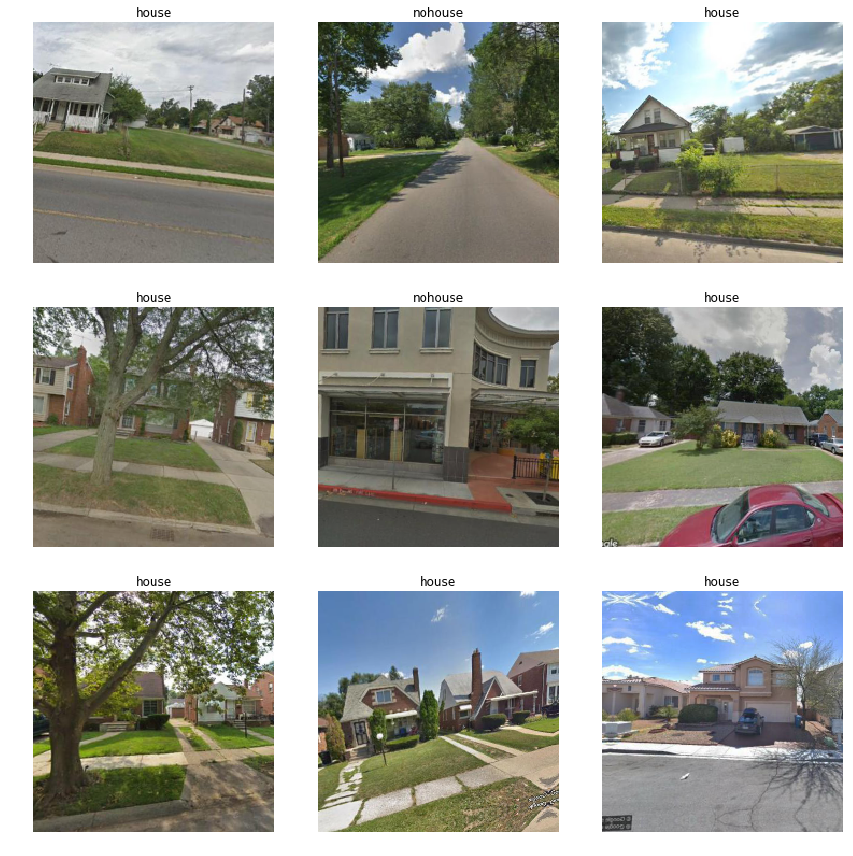

In [12]:
data.show_batch(rows=3)

# Test-set Gallery
Please note, test dataset has no label, the label here is used for Pytorch Dataloader to be consistant with the model

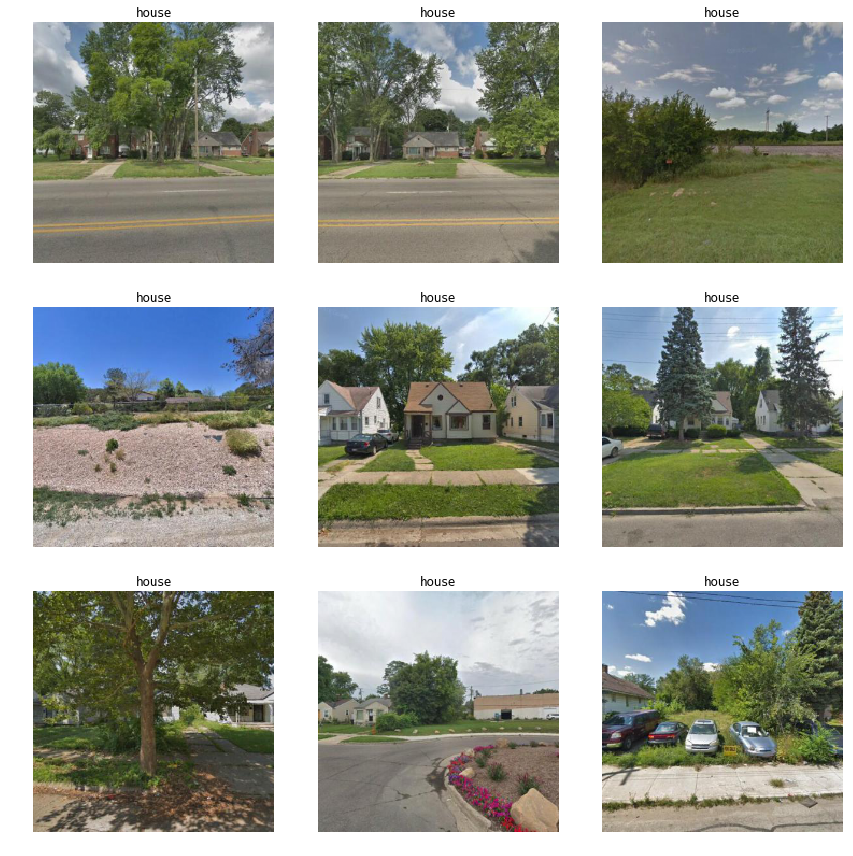

In [13]:
data.show_batch(rows=3,ds_type=DatasetType.Test)

In [14]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['house', 'nohouse'], 2, 90, 22)

# Modeling
* using pre-trained Imagenet Resnet18 with customzied head to predict house/no_house
* Also output confidence probablity as result

In [15]:
learn = cnn_learner(data,models.resnet18,metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 2.51E-02


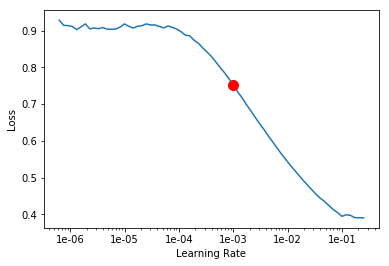

In [16]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [17]:
learn.fit_one_cycle(6,slice(2e-3))

The model is still underfitting, we can try to train a bit longer, also start to adjust the ImageNet pre-trained weights

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-04
Min loss divided by 10: 1.91E-03


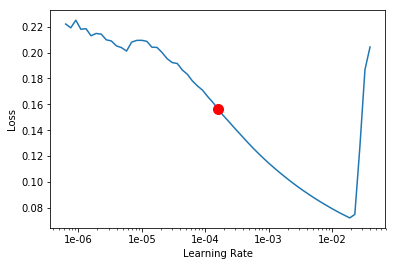

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [20]:
learn.fit_one_cycle(20,slice(2e-6,1e-3))

The validation loss at the last epoch descreased, it should be at the edge of overfitting, we can also train more epochs to see overfitting, but it should be enought for now.

Also, more data should help the model to acchieve a higher accuracy, as training loss is very close to 0 at the moment.

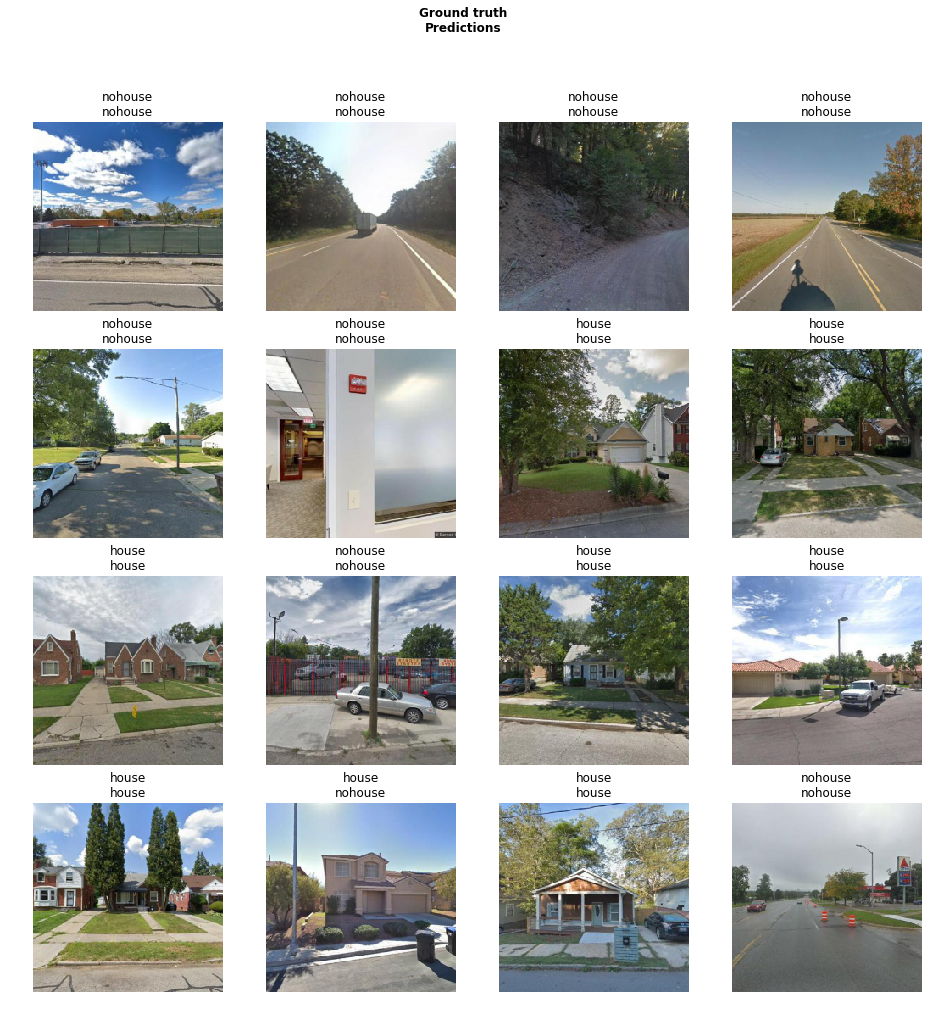

In [21]:
learn.show_results(rows=4)

# Predicting Test-set

In [22]:
%%time
pred_test = learn.get_preds(ds_type=DatasetType.Test)

CPU times: user 356 ms, sys: 304 ms, total: 660 ms
Wall time: 2.84 s


500 images prediction takes about 3s

Let's take a look of the first 10 results

In [24]:
pred_test[0][:10]

tensor([[1.7898e-01, 8.2102e-01],
        [2.7480e-01, 7.2520e-01],
        [1.6091e-02, 9.8391e-01],
        [8.1247e-04, 9.9919e-01],
        [9.9985e-01, 1.4868e-04],
        [2.9819e-01, 7.0181e-01],
        [6.4279e-01, 3.5721e-01],
        [4.8679e-01, 5.1321e-01],
        [4.6160e-01, 5.3840e-01],
        [9.6928e-01, 3.0721e-02]])

In [25]:
results = pred_test[0].argmax(dim=1)

# Adjusting Pytorch Test Dataset to the input URL ordering

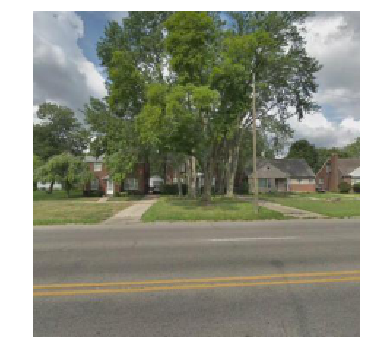

In [26]:
# First Image in the Test dataset
learn.data.test_ds[0][0].show(figsize=(10,6))

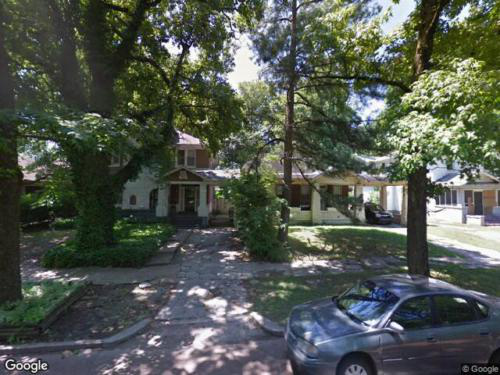

In [27]:
#First Image in the input txt file
open_image(path/'test/00000000.jpg')

# Fin

In [28]:
def prepare_output(data,results):
    f_result = [-1 for i in range(len(results))]
    probality = [-1 for i in range(len(results))]
    for i in range(len(data.test_ds.x.items)):
        try:
            f_result[int(Path(data.test_ds.x.items[i].name).stem.lstrip('0'))] = 'house' if results[i].item()==0 else 'no_house'
            probality[int(Path(data.test_ds.x.items[i].name).stem.lstrip('0'))] = pred_test[0].max(dim=1)[0][i].item()
        except:
            f_result[0] = 'house' if results[i].item()==0 else 'no_house'
            probality[0] = pred_test[0].max(dim=1)[0][i].item()
    return f_result,probality

In [29]:
f_result,probality = prepare_output(data,results)

In [30]:
f_result[:10],probality[:10]

(['house',
  'no_house',
  'no_house',
  'house',
  'no_house',
  'no_house',
  'house',
  'no_house',
  'no_house',
  'house'],
 [0.9588968753814697,
  0.8951163291931152,
  0.8936068415641785,
  0.8966647386550903,
  0.6410695314407349,
  0.705780029296875,
  0.9989544153213501,
  0.9556787610054016,
  0.9841513633728027,
  0.7185447812080383])

In [31]:
df = pd.DataFrame(list(zip(f_result,probality)),columns=['Result','Confidence'])
df.head()

Result  Confidence
0     house    0.958897
1  no_house    0.895116
2  no_house    0.893607
3     house    0.896665
4  no_house    0.641070

In [33]:
df.tail()

Result  Confidence
495  no_house    0.932676
496  no_house    0.611703
497  no_house    0.611703
498     house    0.867682
499  no_house    0.999985

In [32]:
#df.to_csv('500_predictions.csv',index=False)